# **Adversarial Example Generation**

## **Create and train a network to classify CIFAR-10**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras.utils.vis_utils import plot_model
import cv2

In [2]:
(x_train, y_train_class), (x_test, y_test_class) = tf.keras.datasets.cifar10.load_data()
x_train = np.float32(x_train)/255
x_test = np.float32(x_test)/255

# Convert y to one-hot
y_train = tf.keras.utils.to_categorical(y_train_class, 10)
y_test = tf.keras.utils.to_categorical(y_test_class, 10)

170508288/170498071 [==============================] - 11s 0us/step


In [3]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [4]:
def plot_results(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  fig, ax = plt.subplots()
  ax.plot(accuracy,label = 'train')
  ax.plot(val_accuracy,label = 'test')
  ax.set_title('Accuracy')
  ax.legend(loc='lower right')
  fig, ax = plt.subplots()
  ax.plot(loss,label = 'train')
  ax.plot(val_loss,label = 'test')
  ax.set_title('Loss')
  ax.legend(loc='upper right')
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

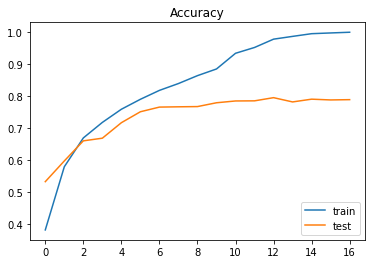

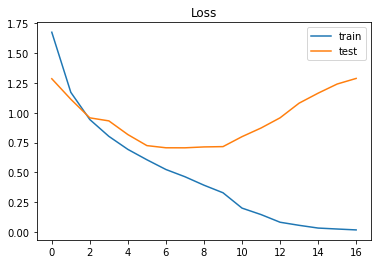

In [5]:
def vgg3(input_shape=(32,32,3)):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation="relu"))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu"))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

rop = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=4)
tob = [TerminateOnBaseline(monitor='accuracy', baseline=1.0)]

cnn = vgg3(input_shape= x_train.shape[1:])
cnn.summary() 
cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
    
history = cnn.fit(
    x_train, y_train,
    epochs =  20, 
    batch_size=256, 
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks =[rop,mc,es,tob]
)

print('Final accuracy on training set: {:.4f}'.format(history.history['accuracy'][-1]))
print('Final accuracy on test set: {:.4f}'.format(history.history['val_accuracy'][-1]))
print('Mean accuracy in last 5 epochs: {:.4f}'.format(np.mean(history.history['val_accuracy'][-5:])))

plot_results(history)

## **Evaluating noisy sensitivity**

Let's see how the trained network classifies noisy examples.

We will add increasingly larger random noise to an image until the network misclassifies it.

Test example chosen 7309 class= 1
Noise: maximum absolute = 0.0000, mean squared = 0.0000
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


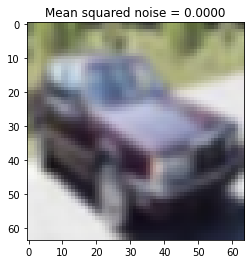

Noise: maximum absolute = 0.0383, mean squared = 0.0001
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


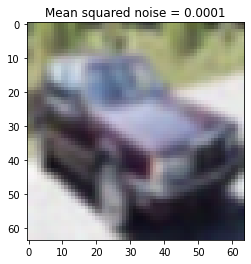

Noise: maximum absolute = 0.0670, mean squared = 0.0004
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


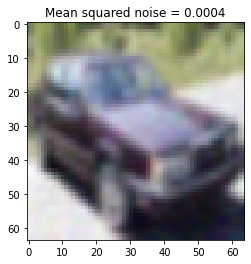

Noise: maximum absolute = 0.1097, mean squared = 0.0009
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


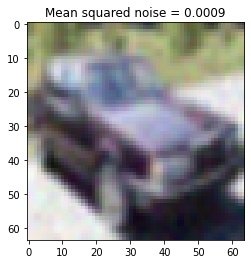

Noise: maximum absolute = 0.1414, mean squared = 0.0016
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


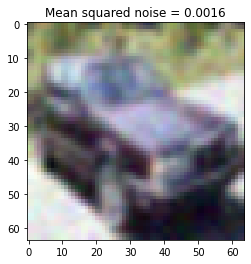

Noise: maximum absolute = 0.1627, mean squared = 0.0024
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


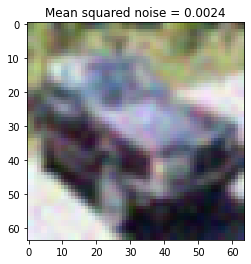

Noise: maximum absolute = 0.2134, mean squared = 0.0037
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


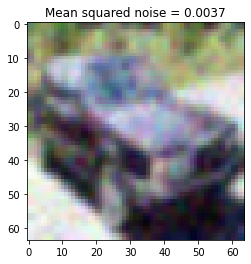

Noise: maximum absolute = 0.2654, mean squared = 0.0048
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


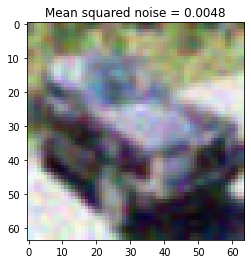

Noise: maximum absolute = 0.2825, mean squared = 0.0062
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


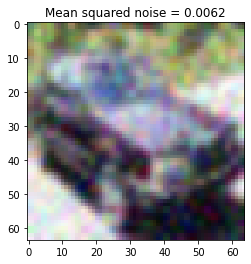

Noise: maximum absolute = 0.3039, mean squared = 0.0076
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


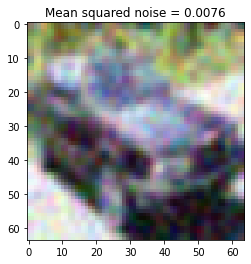

Noise: maximum absolute = 0.3546, mean squared = 0.0095
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


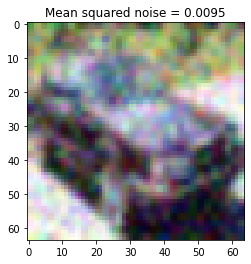

Noise: maximum absolute = 0.3673, mean squared = 0.0112
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


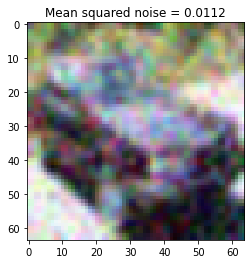

Noise: maximum absolute = 0.4537, mean squared = 0.0134
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


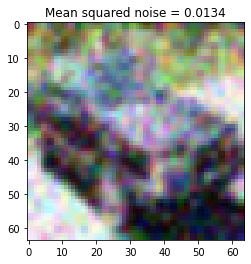

Noise: maximum absolute = 0.5232, mean squared = 0.0159
Network output = 0.00000 0.99926 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00075 
Predicted class = 1
Confidence = 0.9993


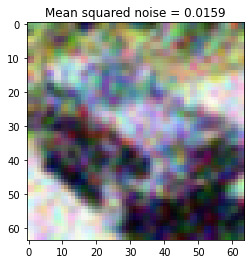

Noise: maximum absolute = 0.5085, mean squared = 0.0175
Network output = 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
Predicted class = 1
Confidence = 1.0000


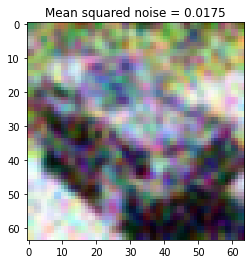

Noise: maximum absolute = 0.5565, mean squared = 0.0201
Network output = 0.00000 0.99985 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00014 
Predicted class = 1
Confidence = 0.9999


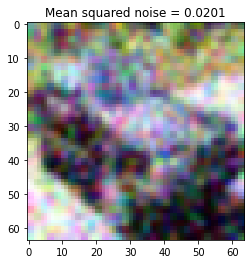

Noise: maximum absolute = 0.5333, mean squared = 0.0230
Network output = 0.00000 0.83353 0.00000 0.00000 0.00000 0.00000 0.00002 0.00000 0.00000 0.16645 
Predicted class = 1
Confidence = 0.8335


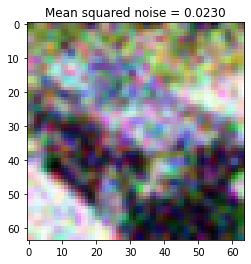

Noise: maximum absolute = 0.5631, mean squared = 0.0254
Network output = 0.00000 0.86720 0.00000 0.00000 0.00000 0.00000 0.00026 0.00000 0.00000 0.13255 
Predicted class = 1
Confidence = 0.8672


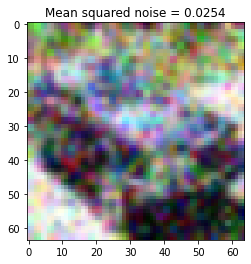

Noise: maximum absolute = 0.5529, mean squared = 0.0286
Network output = 0.00000 0.11875 0.00001 0.00001 0.00000 0.00000 0.58017 0.00000 0.00000 0.30106 
Predicted class = 6
Confidence = 0.5802


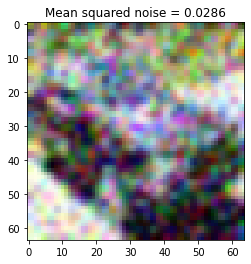

In [7]:
example = np.random.randint(x_test.shape[0])
img = x_test[example]
img_class = np.argmax(y_test[example])
print('Test example chosen',example,'class=',img_class)

show_images = True

for noise in np.linspace(0,1,100):
    # Add gaussian noise with zero mean
    noisy_img = img + np.random.normal(loc=0.0, scale=noise, size=img.shape)
    # Clip image to the 0-1 range
    noisy_img = np.clip(noisy_img,0,1)
    # Compute the noise that was applied 
    real_noise = noisy_img-img
    # Find network output
    pred = cnn.predict(np.expand_dims(noisy_img, 0))[0]
    print('Noise: maximum absolute = {:6.4f}, mean squared = {:6.4f}'.format(np.amax(np.abs(real_noise)),np.mean(np.square(real_noise))))
    print('Network output =',end=' ')
    for p in pred:
      print('{:7.5f}'.format(p),end=' ')
    print()
    print('Predicted class =',np.argmax(pred))
    print('Confidence = {:6.4f}'.format(np.amax(pred)))
    if show_images:
        plt.figure()
        plt.imshow(cv2.resize(noisy_img, dsize=(64,64)))
        plt.title('Mean squared noise = {:.4f}'.format(np.mean(np.square(real_noise))))
        plt.show()
        
    if img_class!=np.argmax(pred): # Exit if image was misclassified
      break

Now let's try using uniformly distributed noise.

In [8]:
example = np.random.randint(x_test.shape[0])
img = x_test[example]
img_class = np.argmax(y_test[example])
print('Test example chosen',example,'class=',img_class)

show_images = True

for noise in np.linspace(0,1,100):
    # Add uniform noise with zero mean
    noisy_img = img + np.random.uniform(-noise,noise, size=img.shape)
    # Clip image to the 0-1 range
    noisy_img = np.clip(noisy_img,0,1)
    # Compute the noise that was applied 
    real_noise = noisy_img-img
    # Find network output
    pred = cnn.predict(np.expand_dims(noisy_img, 0))[0]
    print('Noise: maximum absolute = {:6.4f}, mean squared = {:6.4f}'.format(np.amax(np.abs(real_noise)),np.mean(np.square(real_noise))))
    print('Network output =',end=' ')
    for p in pred:
      print('{:7.5f}'.format(p),end=' ')
    print()
    print('Predicted class =',np.argmax(pred))
    print('Confidence = {:6.4f}'.format(np.amax(pred)))
    if show_images:
        plt.figure()
        plt.imshow(cv2.resize(noisy_img, dsize=(128,128)))
        plt.title('Mean squared noise = {:.4f}'.format(np.mean(np.square(real_noise))))
        plt.show()
    if img_class!=np.argmax(pred): # Exit if image was misclassified
      break

As we can see, the network is very robust to noise. It classifies images correctly even when the noise levels are very high.

## **Generating Adversarial Examples**

It turns out that if we extract information from the network, it is surprisingly easy to generate example that will be classified incorrectly.

We will write a function that will receive the following:

* A trained network N
* An image I
* A target class t, (pressumably different from the images actual class)

And it will return an image that is very similar to I, but is classified by N as belonging to class t.

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.regularizers import l1_l2, l2, l1
from tensorflow.python.keras import backend as K
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from tensorflow.python.keras import backend as K
from keras.regularizers import l1_l2, l2, l1

In [ ]:
np.prod(x_train.shape[1:])

In [ ]:
one = Input(shape=(1,),name='one')
image = Input(shape=x_train.shape[1:],name='image')
noise = Dense(np.prod(x_train.shape[1:]),activation = None,use_bias=False,kernel_initializer=tf.keras.initializers.Constant(0))(one)  
noise = Reshape(x_train.shape[1:],name='reshape')(noise)
net = Add(name='add')([noise,image])
outputs = cnn(net)
adversarial_model = Model(inputs=[image,one], outputs=outputs)
adversarial_model.layers[-1].trainable = False
plot_model(adversarial_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Since images have to be in the [0,1] range, we need to add a "clip" after adding the input and the noise.

In [ ]:
one = Input(shape=(1,),name='one')
image = Input(shape=x_train.shape[1:],name='image')
noise = Dense(np.prod(x_train.shape[1:]),activation = None,use_bias=False,kernel_initializer=tf.keras.initializers.Constant(0))(one)  
noise = Reshape(x_train.shape[1:],name='reshape')(noise)
net = Add(name='add')([noise,image])
net = Lambda(lambda  x: K.clip(x, 0.0,1.0),name='clip')(net)
outputs = cnn(net)
adversarial_model = Model(inputs=[image,one], outputs=outputs)
adversarial_model.layers[-1].trainable = False
plot_model(adversarial_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

We will train the network to produce the desired (wrong) output. 

However, since we want to fool the original network, we make that part of the network not trainable, thus the only parameters that we will modify during training are the weights in the dense layer.

Since we are generating a single adversarial image, we will train the network until an accuracy of 1 is attained on that training set of size 1.

When we are done training, the weights in that layer will correspond to the noise we need to add to the image, and the output of the clip layer is the adversarial image. 

Since we want to add the smallest perturbation that causes a misclassification, we use L2 regularization (penalizing the weights' squared values).

Let's put all the code together in a function.

In [ ]:
def generate_adversarial(input_image,trained_model,target_class,regularization):
  image = Input(shape=input_image.shape,name='image')
  one = Input(shape=(1,),name='one')
  noise = Dense(np.prod(input_image.shape),activation = None,use_bias=False,kernel_initializer=tf.keras.initializers.Constant(0),
                  kernel_regularizer=regularization, name='adversarial_noise')(one)  
  noise = Reshape(input_image.shape,name='reshape')(noise)
  net = Add(name='add')([noise,image])
  net = Lambda(lambda  x: K.clip(x, 0.0,1.0))(net)
  outputs = trained_model(net)
  adversarial_model = Model(inputs=[image,one], outputs=outputs)
  adversarial_model.layers[-1].trainable = False
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
  adversarial_model.compile(optimizer=optimizer,loss="categorical_crossentropy", metrics=["accuracy"])
  target_vector = np.zeros((1,10))
  target_vector[0,target_class] = 1.
  tob = [TerminateOnBaseline(monitor='accuracy', baseline=1)]
  adversarial_model.fit(x={'image':np.expand_dims(input_image,0),'one':np.ones((1,1))},
                        y=target_vector, epochs=2000, verbose=0, callbacks=[tob])
  noise = adversarial_model.get_weights()[0].reshape(input_image.shape)
  adversarial_image = input_image + noise
  adversarial_image = np.clip(adversarial_image,0.0,1.0)
  return adversarial_image

In [ ]:
def print_array(x, fmt = '{:7.5f}'):
  for p in x:
    print(fmt.format(p),end=' ')
  print()

In [ ]:
print_array(pred_clean)

In [ ]:
class_names= ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
example = 5000
example = np.random.randint(0,x_test.shape[0])
img = x_test[example]

pred_clean = cnn.predict(np.expand_dims(img,0))[0]
print('Original network output')
print_array(pred_clean)


target_class = np.argsort(pred_clean)[-2] # Predict second most likely class
#target_class = np.argsort(pred_clean)[0] # Predict least likely class

actual_class = np.argmax(y_test[example])
print('Actual class',actual_class,class_names[actual_class])
print('Target class',target_class,class_names[target_class])

adversarial_img = generate_adversarial(img,cnn,target_class,l2(1))
real_noise = adversarial_img-img

pred = cnn.predict(np.expand_dims(adversarial_img,0))[0]

print('Noise: maximum absolute = {:6.4f}, mean absolute = {:8.6f}'.format(np.amax(np.abs(real_noise)),np.mean(np.abs(real_noise))))
print('Network output =',end=' ')
for p in pred:
    print('{:7.5f}'.format(p),end=' ')
print()
print('Predicted class =',np.argmax(pred))
print('Confidence = {:6.4f}'.format(np.amax(pred)))

if show_images:
  plt.figure()
  plt.imshow(cv2.resize(img, dsize=(128,128)))
  plt.title('Original image')
  plt.figure()
  plt.imshow(cv2.resize(adversarial_img, dsize=(128,128)))
  plt.title('Adversarial image')
